# Predicción de generación Solar
El presente documento tiene por objetivo realizar un estudio sobre la predicción de la producción de una planta solar en India. Los datos corresponden a 34 días. Intentaremos responder la siguientes preguntas:
- ¿Podemos predecir la generación eléctrica para los próximos días?
- ¿Podemos identificar la necesidad de limpieza del panel?
- ¿Podemos identificar alguna falla o baja en el rendimiento de los paneles?

Antes de partir con el análisis, importaremos los módulos necesarios. Pandas, Seabron y Sckit Learn serán nuestros paquetes principales.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
#xformatter = mdates.DateFormatter('%H:%M')
sns.set_style("darkgrid")
sns.set_context("paper")
#sns.set(rc={'figure.figsize':(11.7,8.27)})

A continuación se hará la lectura del archivo que contiene la información de la planta de generación. En ella encontraremos las siguientes columnas:
- **DATE_TIME**: Dato temporal, indica el tiempo en el cual se realizó la medición.
- **PLANT_ID**: La identificación de la planta, por ende, en todo el archivo es igual.
- **SOURCE_KEY**: ID del inversor.
- **DC_POWER**: Cantidad de corriente directa generada en un periodo de 15 minutos, medida en kW.
- **AC_POWER**: Cantidad de corriente alterna generada en un periodo de 15 minutos, medida en kW.
- **DAILY_YIELD**: Cantidad de energía diaria acumulada hasta ese punto en el tiempo.
- **TOTAL_YIELD**: Cantidad de energía acumulada en ese inversor, hasta ese punto en el tiempo.

In [2]:
plant = 'Plant_1'

In [3]:
filename = 'archive/' + plant + '_Generation_Data.csv'
df = pd.read_csv(filename)
df.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
# Convert the 'DATE_TIME' column to datetime format
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'], format='%d-%m-%Y %H:%M')
df['TIME'] = df['DATE_TIME'].dt.time
df['DATE'] = df['DATE_TIME'].dt.date

In [5]:
# Handle missing values
df.fillna(0, inplace=True)

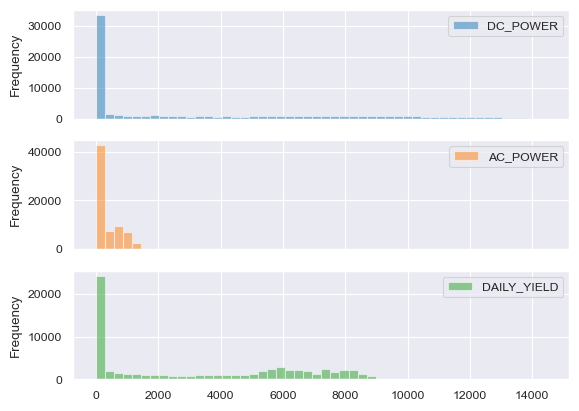

In [6]:
# Histograms of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD'
df[['DC_POWER', 'AC_POWER', 'DAILY_YIELD']].plot(kind='hist', bins=50, alpha=0.5, subplots=True)
plt.show()

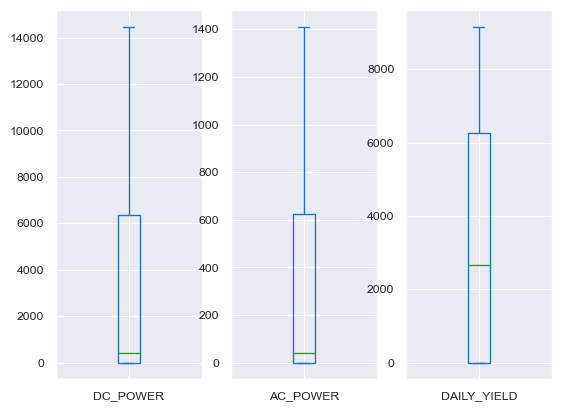

In [7]:
# Boxplots of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD'
df[['DC_POWER', 'AC_POWER', 'DAILY_YIELD']].plot(kind='box', subplots=True)
plt.show()

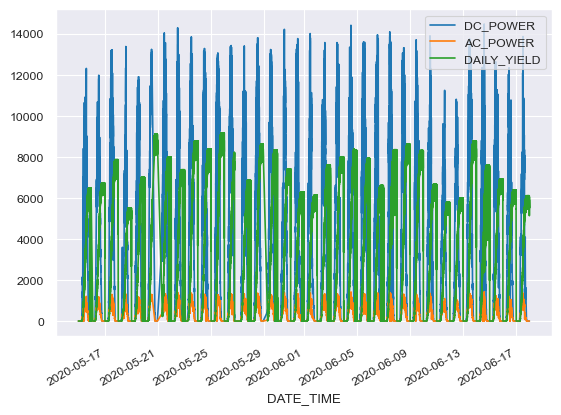

In [8]:
# Line plot of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD' over time
df.plot(x='DATE_TIME', y=['DC_POWER', 'AC_POWER', 'DAILY_YIELD'], kind='line')
plt.show()

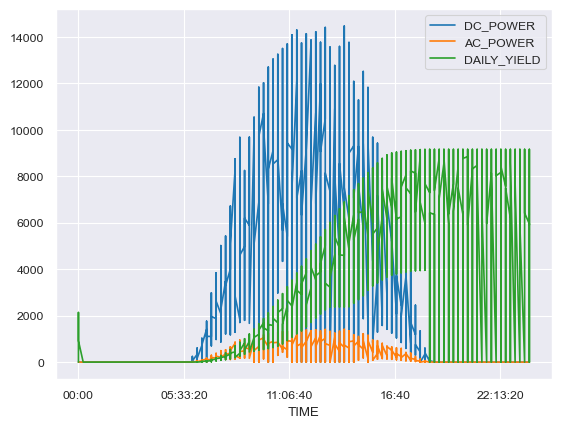

In [9]:
# Line plot of 'DC_POWER', 'AC_POWER', 'DAILY_YIELD' over time
df.plot(x='TIME', y=['DC_POWER', 'AC_POWER', 'DAILY_YIELD'], kind='line')
plt.show()

In [10]:
# Basic statistics
print(df[['DC_POWER', 'AC_POWER', 'DAILY_YIELD']].describe())

           DC_POWER      AC_POWER   DAILY_YIELD
count  68778.000000  68778.000000  68778.000000
mean    3147.426211    307.802752   3295.968737
std     4036.457169    394.396439   3145.178309
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%      429.000000     41.493750   2658.714286
75%     6366.964286    623.618750   6274.000000
max    14471.125000   1410.950000   9163.000000


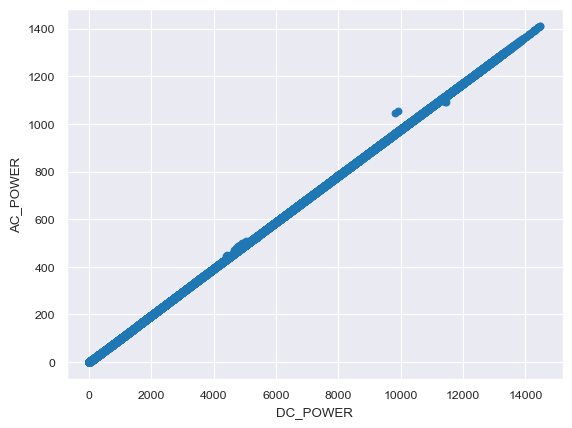

In [11]:
# Scatter plots
plt.scatter(df['DC_POWER'], df['AC_POWER'])
plt.xlabel('DC_POWER')
plt.ylabel('AC_POWER')
plt.show()

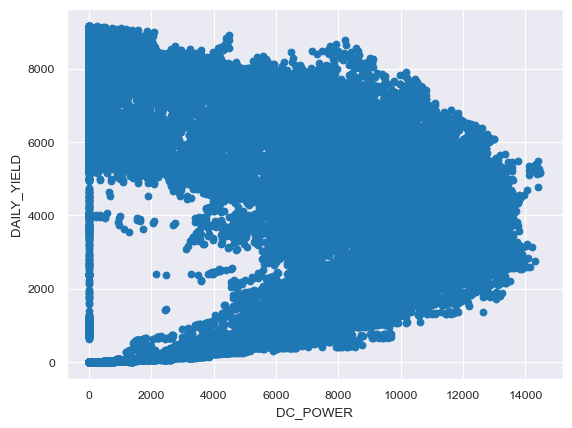

In [12]:
plt.scatter(df['DC_POWER'], df['DAILY_YIELD'])
plt.xlabel('DC_POWER')
plt.ylabel('DAILY_YIELD')
plt.show()

A continuación se hará la lectura del archivo que contiene la información de la planta de generación. En ella encontraremos las siguientes columnas:
- **DATE_TIME**: Dato temporal, indica el tiempo en el cual se realizó la medición.
- **PLANT_ID**: La identificación de la planta, por ende, en todo el archivo es igual.
- **SOURCE_KEY**: ID del inversor.
- **AMBIENT_TEMPERATURE**: Temperatura ambiente del lugar, por las unidades se asume en °C.
- **MODULE_TEMPERATURE**: Temperatura del modulo del panel solar, por las unidades se asume en °C.
- **IRRADIATION**: Corresponde a la radiación en la zona, medido en kW/m2.


In [13]:
filename = 'archive/' + plant + '_Weather_Sensor_Data.csv'
df_plant = pd.read_csv(filename)
df_plant.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


In [14]:
# Convert the 'DATE_TIME' column to datetime format
df_plant['DATE_TIME'] = pd.to_datetime(df_plant['DATE_TIME'], format='%Y%m%d %H:%M:%S')
df_plant['TIME'] = df_plant['DATE_TIME'].dt.time
df_plant['DATE'] = df_plant['DATE_TIME'].dt.date

In [15]:
# Handle missing values
df_plant.fillna(0, inplace=True)

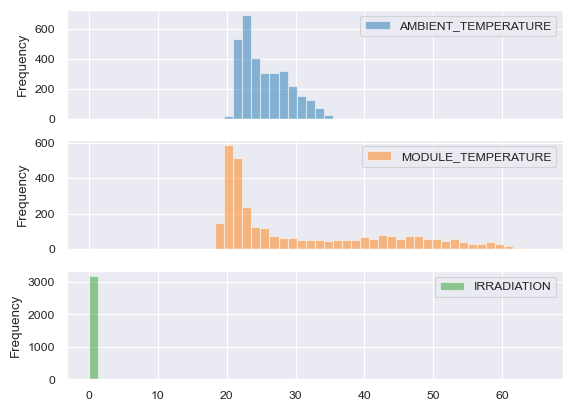

In [16]:
# Histograms of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'
df_plant[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].plot(kind='hist', bins=50, alpha=0.5, subplots=True)
plt.show()

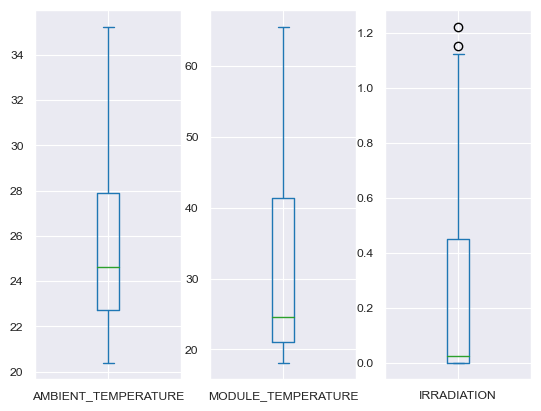

In [17]:
# Boxplots of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'
df_plant[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].plot(kind='box', subplots=True)
plt.show()

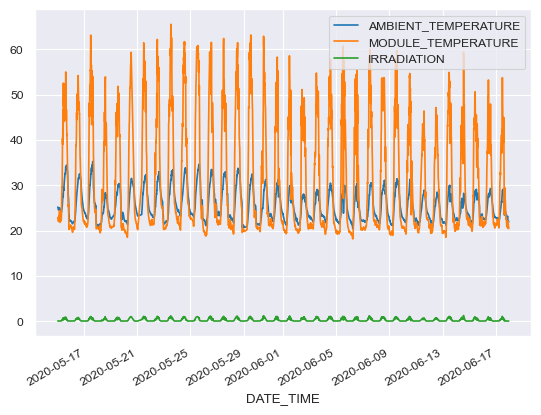

In [18]:
# Line plot of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION' over time
df_plant.plot(x='DATE_TIME', y=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], kind='line')
plt.show()

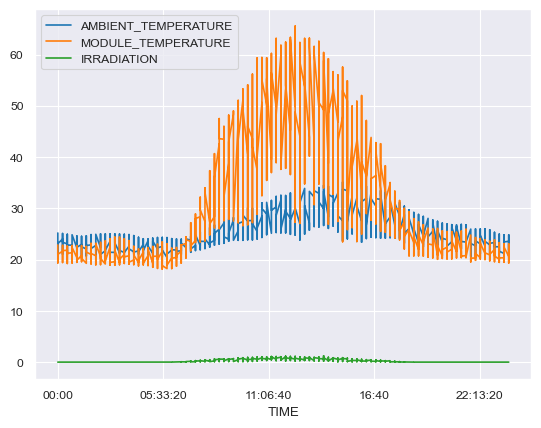

In [19]:
# Line plot of 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION' over time
df_plant.plot(x='TIME', y=['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION'], kind='line')
plt.show()

In [20]:
# Basic statistics
print(df_plant[['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']].describe())

       AMBIENT_TEMPERATURE  MODULE_TEMPERATURE  IRRADIATION
count          3182.000000         3182.000000  3182.000000
mean             25.531606           31.091015     0.228313
std               3.354856           12.261222     0.300836
min              20.398505           18.140415     0.000000
25%              22.705182           21.090553     0.000000
50%              24.613814           24.618060     0.024653
75%              27.920532           41.307840     0.449588
max              35.252486           65.545714     1.221652


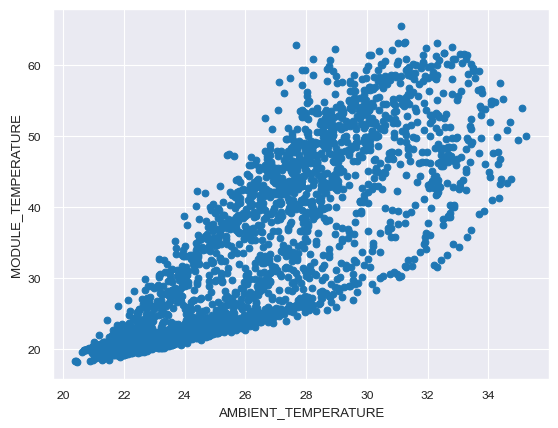

In [21]:
# Scatter plots
plt.scatter(df_plant['AMBIENT_TEMPERATURE'], df_plant['MODULE_TEMPERATURE'])
plt.xlabel('AMBIENT_TEMPERATURE')
plt.ylabel('MODULE_TEMPERATURE')
plt.show()

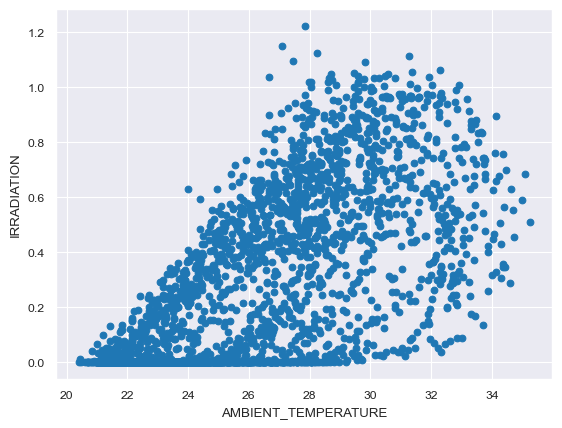

In [22]:
plt.scatter(df_plant['AMBIENT_TEMPERATURE'], df_plant['IRRADIATION'])
plt.xlabel('AMBIENT_TEMPERATURE')
plt.ylabel('IRRADIATION')
plt.show()

In [23]:
# Create a new dataframe with only the 'DATE_TIME' and 'DC_POWER' columns
df_power = df[['DATE_TIME', 'DC_POWER']]

In [24]:
# Set the 'DATE_TIME' column as the index of the dataframe
df_power.set_index('DATE_TIME', inplace=True)

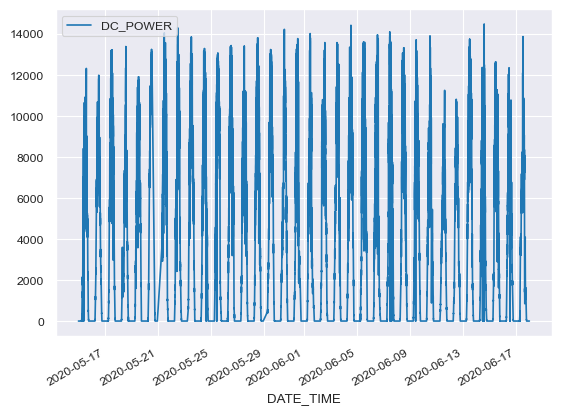

In [25]:
# Visualize the time series data
df_power.plot(y='DC_POWER')
plt.show()

In [26]:
df_power.dropna()

,DC_POWER
DATE_TIME,
2020-05-15 00:00:00,0.0
2020-05-15 00:00:00,0.0
2020-05-15 00:00:00,0.0
2020-05-15 00:00:00,0.0
2020-05-15 00:00:00,0.0
...,...
2020-06-17 23:45:00,0.0
2020-06-17 23:45:00,0.0
2020-06-17 23:45:00,0.0


In [27]:
df_plant

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,TIME,DATE
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,00:00:00,2020-05-15
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,00:15:00,2020-05-15
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,00:30:00,2020-05-15
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,00:45:00,2020-05-15
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,01:00:00,2020-05-15
...,...,...,...,...,...,...,...,...
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0,22:45:00,2020-06-17
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0,23:00:00,2020-06-17
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0,23:15:00,2020-06-17
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0,23:30:00,2020-06-17


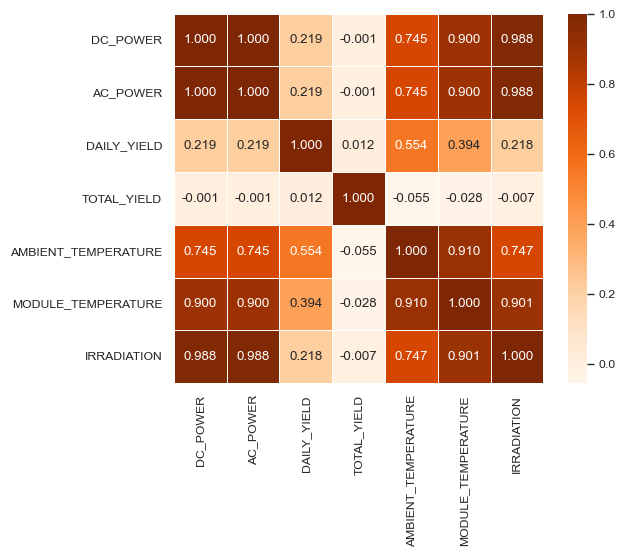

In [28]:
df = pd.merge(df.drop(['PLANT_ID'], axis=1), df_plant.drop(['TIME', 'DATE', 'PLANT_ID', 'SOURCE_KEY'], axis=1), on='DATE_TIME')
#df = df[df['SOURCE_KEY'] == '1BY6WEcLGh8j5v7'].drop('PLANT_ID', axis=1)
corr = df.corr(method = 'spearman')
plt.figure(dpi=100)
sns.heatmap(corr, robust=True, annot=True, fmt='0.3f', linewidths=.5, square=True, cmap='Oranges')
plt.show()

Es posible ver que existen correlaciones entre varias variables, por lo que se podría crear un modelo de regresión para estimar la generación del panel a partir de algún elemento medioambiental (como temperatura ambiente). También podríamos intentar predecir la generación futura de los paneles a partir de la generación histórica (son dos formas de abordar el problema, veamos cual tiene un mejor comportamiento).

In [29]:
filename = 'Data/' + plant + '_wraped.csv'
df.to_csv(filename, index=False)